***
# Basic constants and functions:
***

In [1]:
import numpy as np
import sympy as sym
import scipy as sc
import matplotlib.pyplot as plt
import scienceplots
import time
from scipy.optimize import curve_fit
from scipy.signal import hilbert,convolve
from scipy.fft import fft,ifft
from scipy.integrate import quad,simpson

plt.style.use(['science','notebook', 'grid', 'default', 'bright'])

plot_height = 8    #Plot size parameters
plot_width = plot_height*1.618

SMALL_SIZE = 30    #used to adjust figure font size
MEDIUM_SIZE = 40
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size (glitch in matplotlib?)

sym.init_printing()

xp = 1/np.sqrt(2)*np.array([[1],[1]]) #spin states
xm = 1/np.sqrt(2)*np.array([[1],[-1]])
yp = 1/np.sqrt(2)*np.array([[1],[1j]])
ym = 1/np.sqrt(2)*np.array([[1],[-1j]])
zp = np.array([[1],[0]])
zm = np.array([[0],[1]])

sx = np.array([[0,1],[1,0]]) #Pauli operators
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])

def pol(wf):
    """Returns polarization vector from wavefuction."""
    temp = [np.dot(i,wf) for i in [sx,sy,sz]]
    return np.array([np.real(np.dot(wf.conj().T,temp[i])[0][0]) for i in range(3)])

def get_vg(lam):
    """Returns neutron group velocity (cm/us) from wavelength (Angstroms)."""
    return (6.62607015/1.674927471)/lam*1e-1

def tuning_perfect_rf(b0,amp,freq):
    """Rabi solution function with our Hamiltonian."""
    rabi = np.sqrt((freq - abs(GAMMA)*b0)**2 + (GAMMA*amp/2)**2)
    return 1-2*(GAMMA*AMP/2/rabi)**2*np.sin(rabi*BEAM_TIME/2)**2

def tuning_gaussian(b0,amp,av,sig):
    """Gaussian for fitting the static tuning curve."""
    return 1-2*amp*np.exp(-(b0-av)**2/(2*sig**2))

def tuning_sig_pseudovoigt(b,amp,freq,av,sig,gamma,a,f):
    """Asymmeric pseudo-Voigt function for static tuning curve."""
    return 1-2*amp*np.cos((b-av)*freq)**2*sig_pseudovoigt(b,av,sig,gamma,a,f)[0]

def sig_voigt(b,av,sig,gamma,a):
    """Convolution of gaussian and Lorentzian peak where the width
    of the Lorentzian is allowed to vary sigmoidally, resulting in
    an asymmetric peak. NOT WORKING."""
    G = 1/np.sqrt(2*np.pi)/sig*np.exp(-(b-av)**2/2/sig**2)
    scale = gamma/(1+np.exp(a*(b-av)))
    L = scale/np.pi/((b-av)**2 + scale**2)
    L = L/simpson(L,b)
    result = convolve(G,L,mode='same')
    #need to fix shift here, only true for centered scans with ODD number of points
    return result/simpson(result,b),G,L

def sig_pseudovoigt(b,av,sig,gamma,a,f):
    """Linear mixing approximation to sig_voigt with f as the mixing parameter."""
    assert f>=0 and f<=1
    G = 1/np.sqrt(2*np.pi)/sig*np.exp(-(b-av)**2/2/sig**2)
    scale = gamma/(1+np.exp(a*(b-av)))
    L = scale/np.pi/((b-av)**2 + scale**2)
    L = L/simpson(L,b)
    result = f*L + (1-f)*G
    return result/simpson(result,b),G,L

***
# Analytical Crack-Nicolson Matrix:
***

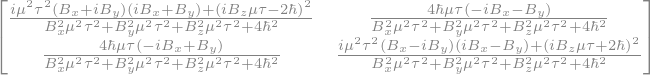

Component:  0


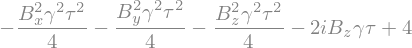

Component:  1


Component:  2


Component:  3


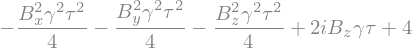

'Denominator:'

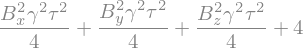

In [2]:
x,y,z,t,p,n1,n2,n3 = sym.symbols('x,y,z,t,phi,n_1,n_2,n_3', real=True)
mu, hbar, ts, g, om = sym.symbols('mu,hbar,tau,gamma,omega', real=True, positive=True)
Bx,By,Bz = sym.symbols('B_x,B_y,B_z', real=True)
Bz = sym.Symbol('B_z', real=True, positive=True)

idt,spx,spy,spz = sym.eye(2),sym.Matrix([[0,1],[1,0]]),sym.Matrix([[0,-sym.I],[sym.I,0]]),sym.Matrix([[1,0],[0,-1]])

Ham = mu*(Bx*spx+By*spy+Bz*spz)

Back = ((idt + sym.I*ts/(2*hbar)*Ham)**-1)
For = (idt - sym.I*ts/(2*hbar)*Ham)
Tot = sym.simplify(Back*For)
display(Tot)

nTot = Tot.subs({hbar:1,mu:g/2})
for i in range(4):
    n,d = sym.fraction(nTot[i])
    n = sym.expand(n)
    print('Component: ', i)
    display(n)
display('Denominator:',d)

RF flipper Hamiltonian:


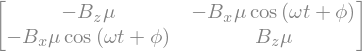

Rotating frame Hamiltonian showing both rotation and nutation:


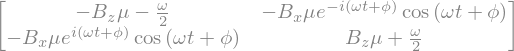

Time-averaged Hamiltonian in the rotating frame:


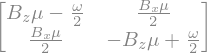

In [7]:
RFHam = -mu*(Bz*spz + Bx*sym.cos(om*t+p)*spx)
print('RF flipper Hamiltonian:')
display(RFHam)
rot = sym.exp(-sym.I*(om*t+p)/2*spz).simplify()
invrot = sym.exp(sym.I*(om*t+p)/2*spz).simplify()
td = om/2*spz #from time derivative
rotframe = rot*RFHam*invrot - td 
rotframe = rotframe.simplify()
print('Rotating frame Hamiltonian showing both rotation and nutation:')
display(rotframe.simplify())
tav_rotframe = sym.Matrix([[Bz*mu,mu*Bx/2],\
                           [mu*Bx/2,-Bz*mu]]) - td #averaged over many nutations, so cos^2->sin^2->1/2
print('Time-averaged Hamiltonian in the rotating frame:')
display(tav_rotframe)

Symmetric RF flipper Hamiltonian:


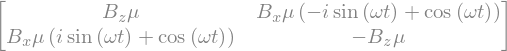

Rotating frame symmetric Hamiltonian showing ONLY rotation:


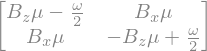

In [4]:
RFHam2 = mu*(Bz*spz+Bx*(sym.cos(om*t)*spx + sym.sin(om*t)*spy))
print('Symmetric RF flipper Hamiltonian:')
display(RFHam2)
rot = sym.exp(sym.I*om*t/2*spz).simplify()
invrot = sym.exp(-sym.I*om*t/2*spz).simplify()
td = om/2*spz #from time derivative
rotframe2 = rot*RFHam2*invrot - td
rotframe2 = rotframe2.simplify()
print('Rotating frame symmetric Hamiltonian showing ONLY rotation:')
display(rotframe2)

Integral result:


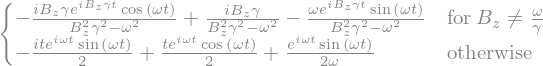

Matrix element:


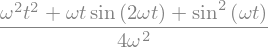

In [5]:
const_f = sym.exp(sym.I*g*Bz*t)*sym.cos(om*t)
const_result = sym.integrate(const_f, (t, 0, t))
print('Integral result:')
display(const_result)
const_ns = const_result.args[0][0]
const_res = const_result.args[1][0]
print('Matrix element:')
const_me = sym.Abs(const_res)**2
display(const_me.simplify())

***
# Definition of magnetic fields and CN matrix:
***

In [ ]:
#Static magnetic field options
def B_rect(z,start,end,n,a):
    """Returns 3D constant magnetic field in given direction n with strength a."""
    normed = n/np.sqrt(np.sum([ni**2 for ni in n])) #normalized input direction
    temp = np.empty(len(z))
    for i,val in enumerate(z):
        temp[i] = i>=start and i<=end
    return np.array([a*ni*temp for ni in normed])

def B_grect(z,start,end,n,a,av,sig,frown=True,fs=1e-2):
    """Returns 3D gaussian magnetic field in given direction n with strength a.
    Frown parameter controls convex/concave profile (fs is frown strength)."""
    normed = n/np.sqrt(np.sum([ni**2 for ni in n])) #normalized input direction
    temp = np.empty(len(z))
    if frown:
        for i,val in enumerate(z):
            temp[i] = (i>=start and i<=end)*np.exp(-(val-av)**2/(2*sig**2))
    else:
        for i,val in enumerate(z):
            temp[i] = (i>=start and i<=end)*(1-fs*np.exp(-(val-av)**2/(2*sig**2)))
    return np.array([a*ni*temp for ni in normed])

def B_smst(z,start,end,n,a):
    """Returns 3D smoothed step function of magnetic field in given direction n with strength a"""
    s,e = z[start],z[end]
    normed = n/np.sqrt(np.sum([ni**2 for ni in n])) #normalized input direction
    a0 = (s**3 - 3*s**2*e)/(s - e)**3
    a1 = 6*s*e/(s - e)**3
    a2 = -3*(s + e)/(s - e)**3
    a3 = 2/(s - e)**3
    temp = np.zeros(len(z))
    temp[start:end] = a0 + a1*z[start:end] + a2*z[start:end]**2 + a3*z[start:end]**3
    temp[end:-1] = np.ones(len(Z)-end - 1)
    temp[-1] = 1
    return np.array([a*ni*temp for ni in normed])

def B_noisy(z,start,end,n,a,amps,freqs,phases):
    """Returns static field that is mostly constant but has a tunable level of noise (simple cosines
    of many different frequencies)."""
    normed = n/np.sqrt(np.sum([ni**2 for ni in n]))
    temp = np.full(len(z),a)
    for indx,f in enumerate(freqs):
        temp = amps[indx]*np.cos(z*f + phases[indx]) + temp
    return np.array([ni*temp for ni in normed])

def B_sol(z,start,end,r,a):
    """Returns analytic finite solenoid envelope."""
    s,e = z[start],z[end]
    temp = ((z-s)/np.sqrt((z-s)**2 + r**2) - (z-e)/np.sqrt((z-e)**2 + r**2))
    return a*temp/np.max(temp)

#Time-dependent mangetic field options
def B_gauss(t,amp,av,sig):
    """Returns gaussian field component in time."""
    return amp*np.exp(-(t-av)**2/(2*sig**2))

def B_cos(t,amp,freq,phase):
    """Returns time-harmonic (cosine) magnetic field in time. Use phase=-np.pi/2 for sin."""
    return amp*np.cos(freq*t + phase)

def B_gcos(t,amp,freq,phase,av,sig):
    """Returns time-harmonic (cosine) magnetic field with gaussian envelope in time.
    Use phase=-np.pi/2 for sin."""
    return amp*np.cos(freq*t + phase)*np.exp(-(t-av)**2/(2*sig**2))

def Bt_smst(t,tp_s,tp_e):
    """Returns 3D smoothed step function of magnetic field in given direction n with strength a"""
    s,e = t[tp_s],t[tp_e]
    a0 = (s**3 - 3*s**2*e)/(s - e)**3
    a1 = 6*s*e/(s - e)**3
    a2 = -3*(s + e)/(s - e)**3
    a3 = 2/(s - e)**3
    temp = np.zeros(len(t))
    temp[tp_s:tp_e] = a0 + a1*t[tp_s:tp_e] + a2*t[tp_s:tp_e]**2 + a3*t[tp_s:tp_e]**3
    temp[tp_e:-1] = np.ones(len(t)-tp_e - 1)
    temp[-1] = 1
    return temp

#RF flipper models and functions
def get_rf_flipper(model,t,t_step,z,z_step,v,plot=False):
    """Defines and returns magnetic field from longitudinal RF flipper. Takes in a dictionary that
    determines the RF flipper model. Requires two strings so the parameter lists make sense."""
    if model['static']=='uniform':
        start,end,n,a = model['static_parms']
        Bt_0 = get_Bt(t,t_step,z_step,v,B_rect(z,start,end,n,a))
    elif model['static']=='gaussian':
        start,end,n,a,av,sig = model['static_parms']
        Bt_0 = get_Bt(t,t_step,z_step,v,B_grect(z,start,end,n,a,av,sig))
    elif model['static']=='smooth_step':
        start1,end1,start2,end2,n,a = model['static_parms']
        Bt_0 = get_Bt(t,t_step,z_step,v,B_smst(z,start1,end1,n,a) - B_smst(z,start2,end2,n,a))
    elif model['static']=='noisy':
        start,end,n,a,amps,freqs,phases = model['static_parms']
        Bt_0 = get_Bt(t,t_step,z_step,v,B_noisy(z,start,end,n,a,amps,freqs,phases))
    else:
        raise ValueError('Static field model not found!')
        
    if model['rf']=='uniform': 
        amp,freq,phase = model['rf_parms']
        #Bt_harm = np.array([np.zeros(len(t)),np.zeros(len(t)),B_cos(t,amp,freq,phase)]) #switched rf field
        Bt_harm = np.array([B_cos(t,amp,freq,phase),np.zeros(len(t)),np.zeros(len(t))])
    elif model['rf']=='gaussian':
        amp,freq,phase,av,sig = model['rf_parms']
        Bt_harm = np.array([np.zeros(len(t)),np.zeros(len(t)),\
                            B_gcos(t,amp,freq,phase,av,sig)])
    elif model['rf']=='smooth_step':
        amp,freq,phase,start1,end1,start2,end2 = model['rf_parms']
        Bt_harm = np.array([np.zeros(len(t)),np.zeros(len(t)),\
                            amp*np.cos(freq*t + phase)*(Bt_smst(t,start1,end1) - Bt_smst(t,start2,end2))])
    elif model['rf']=='Fankang':
        amp,freq,phase = model['rf_parms']
        Bt_harm = np.array([B_cos(t,amp,freq,phase-np.pi/2),np.zeros(len(t)),\
                            B_cos(t,amp,freq,phase)])
    else:
        raise ValueError('RF field model not found!')
        
    t_mask = np.array([[True if Bt_0[j,t]*n[j] != 0 else False for t in range(len(t))] for j in range(3)])
    for j in range(len(t)): #"spatial" bounds on rf field are determined by the static field bounds
        if not (t_mask[0,j] or t_mask[1,j] or t_mask[2,j]):
            Bt_harm[0,j],Bt_harm[1,j],Bt_harm[2,j] = 0,0,0
    
    if plot: #rough plot for testing purposes
        fig = plt.figure(figsize=(plot_width,plot_height))
        for i in range(3):
            plt.plot(t,Bt_0[i] + Bt_harm[i])
        plt.grid()
        plt.show()
    
    return Bt_0 + Bt_harm

def get_Bt(t,t_step,z_step,v,B):
    """Returns the field seen by the moving neutron."""
    bpoint = 0
    temp = [np.empty(len(t)),np.empty(len(t)),np.empty(len(t))]
    for i,val in enumerate(t):
        if val*v > z_step*(bpoint + 1):
            bpoint += 1
        temp[0][i] = B[0][bpoint]
        temp[1][i] = B[1][bpoint]
        temp[2][i] = B[2][bpoint]
    return np.array(temp)

def get_CNM(B,t_step):
    """Returns Crank-Nicolson matrix for given magnetic field B."""
    bms = np.sum([i**2 for i in B])
    CNM = np.zeros((2,2),dtype=np.complex_)
    CNM[0,0] = 4 - 2j*B[2]*t_step*GAMMA - (bms*(t_step*GAMMA)**2)/4
    CNM[1,0] = -2j*(B[0] - 1j*B[1])*t_step*GAMMA
    CNM[0,1] = -2j*(B[0] + 1j*B[1])*t_step*GAMMA
    CNM[1,1] = 4 + 2j*B[2]*t_step*GAMMA - (bms*(t_step*GAMMA)**2)/4
    return 1/(bms*(t_step*GAMMA/2)**2 + 4)*CNM

def do_sim(psi_0,Bt_tot,t,t_step,\
           return_psis=False,plot_bt=True,plot_pol=True,pol_on_bt=False,\
           plot_Pi=(True,True,True,False),plot_Bi=(True,True,True,False)):
    """Returns polarization (3D real vector) at every time point. Can return wavefunction matrix,
    but may run into memory issues with numpy?"""
    psi = np.array([np.zeros((2,2),dtype=np.complex_) for i in t]) #holds all wavefunctions

    psi[0] = psi_0 #initial wavefunction
    for i in range(1,len(t)):
        psi[i] = np.dot(get_CNM(Bt_tot[:,i],t_step),psi[i-1])
    pols = np.array([pol(i) for i in psi])
    
    if plot_bt:
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Magnetic field components')
        plt.xlabel('Time (us)')
        plt.ylabel('Strength (mT)')
        if plot_Bi[0]: plt.plot(t, Bt_tot[0], label='Bx(t)', linewidth=5, color='C0')
        if plot_Bi[1]: plt.plot(t, Bt_tot[1], label='By(t)', linewidth=5, color='C1')
        if plot_Bi[2]: plt.plot(t, Bt_tot[2], label='Bz(t)', linewidth=5, color='C2')
        if plot_Bi[3]: 
            plt.plot(t, np.sqrt(Bt_tot[0]**2+Bt_tot[1]**2+Bt_tot[2]**2), '-', label='|B(t)|', linewidth=4, color='C3')
        if pol_on_bt:
            if plot_Pi[0]: plt.plot(t, pols[:,0], '-.', label='Px(t)', linewidth=4, color='C0')
            if plot_Pi[1]: plt.plot(t, pols[:,1], '-.', label='Py(t)', linewidth=4, color='C1')
            if plot_Pi[2]: plt.plot(t, pols[:,2], '-.', label='Pz(t)', linewidth=4, color='C2')
        plt.grid()
        plt.legend()
        plt.show()
    
    if plot_pol:
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Polarization components')
        plt.xlabel('Time (us)')
        plt.ylabel('Pol.')
        if plot_Pi[0]: plt.plot(t, pols[:,0], label='Px(t)', linewidth=5, color='C0')
        if plot_Pi[1]: plt.plot(t, pols[:,1], label='Py(t)', linewidth=5, color='C1')
        if plot_Pi[2]: plt.plot(t, pols[:,2], label='Pz(t)', linewidth=5, color='C2')
        if plot_Pi[3]: plt.plot(t, [np.sqrt(np.sum([i**2 for i in pols[j]])) for j in range(len(pols[:,0]))], '--', \
                                label='|P(t)|', linewidth=4, color='C3')
        plt.grid()
        plt.legend()
        plt.show()
        
    if not return_psis:
        del psi
        return pols
    else:
        return pols, psi

***
## Simulation scans:
***

In [ ]:
def do_model_scan(model_seq1, model_seq2, parm, plots_scans=False,plot_tune=True,return_new=True):
    """Performs a scan of a model. Can compare tuning curves with a
    second model sequence. parm is a tupule of 2 strings that keeps track of the 
    tuning parameter and the scan of the parameter itself. Can also return new
    best flip parameter."""
    pols1 = [[] for m in model_seq1]
    pols2 = [[] for m in model_seq2]
    for indx,m in enumerate(model_seq1):
        Bt = get_rf_flipper(m,T,TAU,Z,DELTA,VG,plot=False)
        pols1[indx] = do_sim(yp,Bt,T,TAU,plot_bt=False,\
                         plot_pol=plots_scans,plot_Pi=(True,True,True,False))
    if len(model_seq2)!=0:
        for indx,m in enumerate(model_seq2):
            Bt = get_rf_flipper(m,T,TAU,Z,DELTA,VG,plot=False)
            pols2[indx] = do_sim(yp,Bt,T,TAU,plot_bt=False,\
                              plot_pol=plots_scans,plot_Pi=(True,True,True,False))
    pols1,pols2 = np.array(pols1),np.array(pols2)
    if plot_tune:
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Tuning curve')
        plt.xlabel(f'{parm[0]} ({parm[1]})')
        plt.ylabel('Exit pol.')
        plt.plot(parm[2], pols1[:,-1,1],'o-',ms=6,linewidth=6)
        if len(model_seq2)!=0:
            plt.plot(parm[2], pols2[:,-1,1],'o-',ms=6,linewidth=6)
        plt.grid()
        plt.show()
        
    new_parm1 = parm[2][np.argmin(pols1[:,-1,1])]
    new_parm2 = parm[2][np.argmin(pols2[:,-1,1])]
    print(f'SEQ1: Min pol of {np.min(pols1[:,-1,1])} at {parm[0]+" "+parm[1]} {round(new_parm1,5)}.')
    print(f'SEQ2: Min pol of {np.min(pols2[:,-1,1])} at {parm[0]+" "+parm[1]} {round(new_parm2,5)}.')
    if return_new: return new_parm1, new_parm2, pols1, pols2
    else: return pols1, pols2

def model_compare(model_1,model_2,plot_b=False):
    """Compares flipping efficiencies between two input models."""
    Bt1 = get_rf_flipper(model_1,T,TAU,Z,DELTA,VG)
    Bt2 = get_rf_flipper(model_2,T,TAU,Z,DELTA,VG)

    pols1 = do_sim(yp,Bt1,T,TAU,plot_bt=plot_b,plot_pol=True,\
                   plot_Bi=(False,True,True,False),plot_Pi=(True,True,True,False))
    pols2 = do_sim(yp,Bt2,T,TAU,plot_bt=plot_b,plot_pol=True,\
                   plot_Bi=(False,True,True,False),plot_Pi=(True,True,True,False))

    print(f'Model 1: Minimum pol: {round(np.min(pols1[:,1]),5)}')
    tmin1 = np.argmin(pols1[:,1])
    print(f'Model 1: Minimum pol at t={round(T[tmin1],5)} \n')
    
    print(f'Model 2: Minimum pol: {round(np.min(pols2[:,1]),5)}')
    tmin2 = np.argmin(pols2[:,1])
    print(f'Model 2: Minimum pol at t={round(T[tmin2],5)} \n')

    print('Model 1: Final pol: ', round(pols1[-1,1],5))
    print('Model 2: Final pol: ', round(pols2[-1,1],5))
    return pols1,pols2

def get_envelope(pols1,pols2,s=0,e=-1,plot=True):
    """Returns oscillation envelopes."""
    env_x1,env_z1 = np.abs(hilbert(pols1[:,0])),np.abs(hilbert(pols1[:,2]))
    env_x2,env_z2 = np.abs(hilbert(pols2[:,0])),np.abs(hilbert(pols2[:,2]))

    if plot: #compares polarizations
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Pol. envelope')
        plt.xlabel('Time (us)')
        plt.ylabel('Pol.')
        plt.plot(T[s:e],env_x1[s:e],'--', color='C0', linewidth=4)
        plt.plot(T[s:e],env_x2[s:e],'-', color='C0', linewidth=4, label='Px')
        plt.plot(T[s:e],pols1[s:e,1],'--', color='C1', linewidth=4)
        plt.plot(T[s:e],pols2[s:e,1],'-', color='C1', linewidth=4, label='Py')
        plt.plot(T[s:e],-env_z1[s:e],'--', color='C2', linewidth=4)
        plt.plot(T[s:e],-env_z2[s:e],'-', color='C2', linewidth=4, label='-Pz')
        plt.grid()
        plt.legend()
        plt.show()     
    return env_x1,env_z1,env_x2,env_z2

def do_stability_check(pols1,pols2,s=-1000,e=-1,plot_exit=True):
    """Plots polarization near the exit of the flipper (or near the minimum
    polarization). Returns nothing."""
    if plot_exit:
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Pol. near flipper exit')
        plt.xlabel('Time (us)')
        plt.ylabel('Pol.')
        plt.plot(T[s:e],pols1[s:e,0], '--', color='C0', linewidth=4)
        plt.plot(T[s:e],pols2[s:e,0], color='C0', linewidth=4, label='Px')
        plt.plot(T[s:e],np.ones(abs(s-e))+pols1[s:e,1], '--', color='C1', linewidth=4)
        plt.plot(T[s:e],np.ones(abs(s-e))+pols2[s:e,1], color='C1', linewidth=4, label='1+Py')
        plt.plot(T[s:e],pols1[s:e,2], '--', color='C2', linewidth=4)
        plt.plot(T[s:e],pols2[s:e,2], color='C2', linewidth=4, label='Pz')
        plt.grid()
        plt.legend()
        plt.show()
    else: #minimum is exit for perfect flipper
        tmin1,pol_min1 = np.argmin(pols1[:,1]), np.min(pols1[:,1])
        tmin2,pol_min2 = np.argmin(pols2[:,1]), np.min(pols2[:,1])
        delta = int(abs(s-e)/2) #symmetric around min
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Pol. near minimum (1)')
        plt.xlabel('Time (us)')
        plt.ylabel('Pol.')
        plt.plot(T[tmin1-delta:tmin1+delta],pols1[tmin1-delta:tmin1+delta,0], linewidth=5, label='Px')
        plt.plot(T[tmin1-delta:tmin1+delta],\
                 1+pols1[tmin1-delta:tmin1+delta,1], linewidth=5, label='1+Py')
        plt.plot(T[tmin1-delta:tmin1+delta],pols1[tmin1-delta:tmin1+delta,2], linewidth=5, label='Pz')
        plt.grid()
        plt.legend()
        plt.show()
        print(f'Minimum of {round(pol_min1,5)} at t={round(T[tmin1],3)} \n')
        
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Pol. near minimum (2)')
        plt.xlabel('Time (us)')
        plt.ylabel('Pol.')
        plt.plot(T[tmin2-delta:tmin2+delta],pols2[tmin2-delta:tmin2+delta,0], linewidth=5, label='Px')
        plt.plot(T[tmin2-delta:tmin2+delta],\
                 1+pols2[tmin2-delta:tmin2+delta,1], linewidth=5, label='1+Py')
        plt.plot(T[tmin2-delta:tmin2+delta],pols2[tmin2-delta:tmin2+delta,2], linewidth=5, label='Pz')
        plt.grid()
        plt.legend()
        plt.show()
        print(f'Minimum of {round(pol_min2,5)} at t={round(T[tmin2],3)} \n')

***
# GLOBAL simulation parameters:
***

In [ ]:
GAMMA = -1.83247171*1e-1 #neutron gyromagnetic ratio (rad per mT us)
HBAR = 1.05457182e-34
M_N = 1.674927498e-27

BEAM_DIST = 2.5 #total beamline length (cm)
Z_POINTS = 200 #number of lattice points
DELTA = BEAM_DIST/Z_POINTS #lattice spacing (cm)
Z = np.linspace(0,BEAM_DIST,Z_POINTS) #space lattice

LAM = 4.5 #neutron wavelength (Angstoms)
VG = get_vg(LAM) #group velocity (cm per us)

BEAM_TIME = BEAM_DIST/VG #total time (us)

R_S,R_E = 0, 199 #start and end points
L_RF = abs(R_E - R_S + 1)*DELTA #RF flipper length (cm)
T_RF = L_RF/VG #time spent inside RF flipper (us)

FREQ = 2*np.pi*.035 #angular RF frequency (rads per us)
AMP = 2*np.pi/(T_RF*abs(GAMMA))
B_0 = FREQ/abs(GAMMA)

TAU = np.pi/(250*FREQ) #time step (us), 250 per nutation periods
T_POINTS = round(BEAM_TIME/TAU) #number of time steps
T = np.linspace(0,BEAM_TIME,T_POINTS) #time lattice

print('Flip parameters:')
print(f'RF freq (kHz): {round(1e3*FREQ/(2*np.pi),3)}')
print(f'RF amp (mT): {round(AMP,3)}')
print(f'Static field (mT): {round(B_0,3)} \n')
print('Fixed coil parameters:')
print(f'Coil length (cm):  {round(L_RF,3)}')
print(f'Flight time (us):  {round(T_RF,3)} \n')
print('Time parameters:')
print(f'Time step size (ns): {round(1e3*TAU,3)}')
print(f'RF period (us): {round(2*np.pi/FREQ,3)}')
print(f'Nutation period (us): {round(np.pi/FREQ,3)}')
print(f'Time steps per nutation period: {round(np.pi/FREQ/TAU,3)}')

### RF flipper models:

In [ ]:
perfect_static = {'static':'uniform','static_parms':(R_S,R_E,(0,1,0),B_0)}
perfect_rf = {'rf':'uniform','rf_parms':(AMP,FREQ,0)}

static_10p = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*1.09)}
static_5p = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*1.56)}
static_1p = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}
static_p1p = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*10)}

static_a = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/4,BEAM_DIST*2.5)}

static_noisy = {'static':'noisy','static_parms':(R_S,R_E,(0,1,0),B_0,\
                [.1,.05,.05],[2*np.pi/BEAM_DIST,3*np.pi/BEAM_DIST,7*np.pi/BEAM_DIST],[np.pi,np.pi/3,np.pi/4])}

static_smst = {'static':'smooth_step','static_parms':(R_S,R_S+10,R_E-10,R_E,(0,1,0),B_0)}

rf_gauss = {'rf':'gaussian','rf_parms':(AMP,FREQ,0,BEAM_TIME/2,BEAM_TIME/6)}
rf_smst = {'rf':'smooth_step','rf_parms':(AMP,FREQ,0,0,int(T_POINTS*.15),int(T_POINTS*.85),T_POINTS-1)}
rf_smerst = {'rf':'smooth_step','rf_parms':(AMP,FREQ,0,0,int(T_POINTS*.3),int(T_POINTS*.7),T_POINTS-1)}
rf_smestst = {'rf':'smooth_step','rf_parms':(AMP,FREQ,0,0,int(T_POINTS*.5),int(T_POINTS*.5),T_POINTS-1)}
rf_data = {'rf':'smooth_step','rf_parms':(AMP,FREQ,0,0,int(T_POINTS*.4),int(T_POINTS*.6),T_POINTS-1)}
rf_a = {'rf':'gaussian','rf_parms':(AMP,FREQ,0,BEAM_TIME/4,BEAM_TIME/8)}

Fankang = {'static':'uniform','rf':'Fankang',\
           'static_parms':(R_S,R_E,(0,1,0),B_0),'rf_parms':(AMP/2,FREQ,0)}

### RF flipper single simulation:

In [ ]:
time_start = time.time()
Bt = get_rf_flipper(perfect_static | perfect_rf,\
                    T,TAU,Z,DELTA,VG,plot=False)
pols = do_sim(yp,Bt,T,TAU,pol_on_bt=False,plot_bt=True,plot_pol=True,\
           plot_Pi=(True,True,True,False),plot_Bi=(True,True,False,False))
time_end = time.time()

print(f'Sim time (sec): {round(time_end-time_start,1)} \n')
print(f'Static field max inhomogeneity: {round((np.max(Bt[1]) - np.min(Bt[1]))/np.max(Bt[1])*100,1)}% \n')

print(f'Minimum pol: {round(np.min(pols[:,1]),5)}')
tmin = np.argmin(pols[:,1])
print(f'Minimum pol at t={round(T[tmin],3)} \n')

print(f'Final pol: {round(pols[-1,1],5)}')
print(f'Final pol at t={round(T[-1],3)}')

***
# 500 kHz Gaussian Static & RF
***

In [ ]:
time_start = time.time()

parm = ('RF Freq', 'rad/us', np.linspace(FREQ-5e-2,FREQ+5e-2,21))
GG_500_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(AMP,p,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PP_500_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),B_0)}|\
              {'rf':'uniform','rf_parms':(AMP,p,0)}\
              for p in parm[2]]
f1,f2,pols1,pol2 = do_model_scan(GG_500_seq, PP_500_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('RF Amp', 'mT', np.linspace(AMP,AMP+1,21))
GG_500_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(p,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PP_500_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),B_0)}|\
              {'rf':'uniform','rf_parms':(p,f2,0)}\
              for p in parm[2]]
a1,a2,pols1,pol2 = do_model_scan(GG_500_seq, PP_500_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('B_0', 'mT', np.linspace(B_0-.25,B_0+.25,21))
GG_500_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PP_500_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),p)}|\
              {'rf':'uniform','rf_parms':(a2,f2,0)}\
              for p in parm[2]]
b1,b2,pols1,pol2 = do_model_scan(GG_500_seq, PP_500_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

new_GG_500 = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b1,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}
new_PP_500 = {'static':'uniform','static_parms':(R_S,R_E,(0,1,0),b2)}|\
                {'rf':'uniform','rf_parms':(a2,f2,0)}

pols1,pols2 = model_compare(new_GG_500,new_PP_500)

time_end = time.time()
print(f'\n Sim time (min): {round((time_end-time_start)/60.,1)}')

### Getting oscillation envelope after tuning

In [ ]:
_ = get_envelope(pols1,pols2,s=100,e=-100,plot=True)
do_stability_check(pols1,pols2)
do_stability_check(pols1,pols2,plot_exit=False)

### Longer static field tuning scan

In [ ]:
time_start = time.time()

parm = ('B_0', 'mT', np.linspace(B_0-.9,B_0+.9,55)) #longer b0 tuning
GG_500_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PP_500_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),p)}|\
              {'rf':'uniform','rf_parms':(a2,f2,0)}\
              for p in parm[2]]
pols1,pols2 = do_model_scan(GG_500_seq, PP_500_seq, parm, plots_scans=False,plot_tune=True,return_new=False)

time_end = time.time()
print(f'\n Sim time (min): {round((time_end-time_start)/60.,1)}')

In [ ]:
def tuning_AG(t,amp,av,sig,a):
    """Returns asymmetric Gaussian with a sigmoidal width for static tuning curve."""
    scale = sig/(1+np.exp(a*(t-av)))
    return 1-2*amp*np.exp(-(t-av)**2/(2*scale**2))
def tuning_sig_pseudovoigt(b,amp,freq,av,sig,gamma,a,f):
    """Asymmeric pseudo-Voigt function for static tuning curve."""
    return 1-2*amp*np.cos((b-av)*freq)**2*sig_pseudovoigt(b,av,sig,gamma,a,f)[0]
def sig_pseudovoigt(b,av,sig,gamma,a,f):
    """Linear mixing approximation to sig_voigt with f as the mixing parameter."""
    assert f>=0 and f<=1
    G = 1/np.sqrt(2*np.pi)/sig*np.exp(-(b-av)**2/2/sig**2)
    scale = gamma/(1+np.exp(a*(b-av)))
    L = scale/np.pi/((b-av)**2 + scale**2)
    L = L/simpson(L,b)
    result = f*L + (1-f)*G
    return result/simpson(result,b),G,L

x_data = parm[2]
y1_data = pols1[:,-1,1]
y2_data = pols2[:,-1,1]

guess1_AG = (1,17.15,.3,0)

fit_AG,err_AG = curve_fit(tuning_AG,x_data,y1_data,p0=guess1_AG)#,bounds=bound)
print(f'Fit asymmetric Gaussian: \n [amp,av,sig,asym] \n {np.round(fit_AG,3)}')
print(f'Errors: \n {np.round(np.sqrt(np.diagonal(err_AG)),3)}')

fig = plt.figure(figsize=(plot_width,plot_height))
plt.title('Fitted tuning scan')
plt.xlabel('B_0 (mT)')
plt.ylabel('Exit pol.')
plt.plot(x_data,y1_data,'.',ms=10, zorder=100)
plt.plot(x_data,y2_data,'.',ms=10,color='C2')
plt.plot(x_data,tuning_AG(x_data,*fit_AG),linewidth=4,label='Fitted')
plt.plot(x_data,tuning_perfect_rf(x_data,AMP,FREQ),'--',linewidth=2,label='Rabi',color='C2')
plt.grid()
plt.legend()
plt.show()

The RF field in this tuning curve has a large variation, so the lorentzian peak is smeared into a Gaussian. The asymmetry in the Gaussian is due to the static field, shown in the cells below. Our data shows quite obvious sub-peaks (ie shoulders), so that tells us the rf amplitude is not really Gaussian in shape, but must be sharper.

***
# 1.25 MHz Gaussian Static & RF
***

In [ ]:
time_start = time.time()

parm = ('RF Freq', 'rad/us', np.linspace(FREQ-5e-2,FREQ+5e-2,21))
GG_1p25_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(AMP,p,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PP_1p25_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),B_0)}|\
              {'rf':'uniform','rf_parms':(AMP,p,0)}\
              for p in parm[2]]
f1,f2,pols1,pol2 = do_model_scan(GG_1p25_seq, PP_1p25_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('RF Amp', 'mT', np.linspace(AMP,AMP+1,21))
GG_1p25_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(p,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PP_1p25_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),B_0)}|\
              {'rf':'uniform','rf_parms':(p,f2,0)}\
              for p in parm[2]]
a1,a2,pols1,pol2 = do_model_scan(GG_1p25_seq, PP_1p25_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('B_0', 'mT', np.linspace(B_0-.25,B_0+.25,21))
GG_1p25_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PP_1p25_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),p)}|\
              {'rf':'uniform','rf_parms':(a2,f2,0)}\
              for p in parm[2]]
b1,b2,pols1,pol2 = do_model_scan(GG_1p25_seq, PP_1p25_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

new_GG_1p25 = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b1,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}
new_PP_1p25 = {'static':'uniform','static_parms':(R_S,R_E,(0,1,0),b2)}|\
                {'rf':'uniform','rf_parms':(a2,f2,0)}

pols1,pols2 = model_compare(new_GG_1p25,new_PP_1p25)

time_end = time.time()
print(f'\n Sim time (min): {round((time_end-time_start)/60.,1)}')

In [ ]:
_ = get_envelope(pols1,pols2,s=100,e=-100,plot=True)
do_stability_check(pols1,pols2)
do_stability_check(pols1,pols2,plot_exit=False)

***
# 2 MHz Gaussian Static & RF
***

In [ ]:
time_start = time.time()

parm = ('RF Freq', 'rad/us', np.linspace(FREQ-5e-2,FREQ+5e-2,21))
GG_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(AMP,p,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PP_2_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),B_0)}|\
              {'rf':'uniform','rf_parms':(AMP,p,0)}\
              for p in parm[2]]
f1,f2,pols1,pol2 = do_model_scan(GG_2_seq, PP_2_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('RF Amp', 'mT', np.linspace(AMP,AMP+1,21))
GG_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(p,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PP_2_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),B_0)}|\
              {'rf':'uniform','rf_parms':(p,f2,0)}\
              for p in parm[2]]
a1,a2,pols1,pol2 = do_model_scan(GG_2_seq, PP_2_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('B_0', 'mT', np.linspace(B_0-.25,B_0+.25,21))
GG_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PP_2_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),p)}|\
              {'rf':'uniform','rf_parms':(a2,f2,0)}\
              for p in parm[2]]
b1,b2,pols1,pol2 = do_model_scan(GG_2_seq, PP_2_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

new_GG_2 = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b1,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}
new_PP_2 = {'static':'uniform','static_parms':(R_S,R_E,(0,1,0),b2)}|\
                {'rf':'uniform','rf_parms':(a2,f2,0)}

pols1,pols2 = model_compare(new_GG_2,new_PP_2)

time_end = time.time()
print(f'\n Sim time (min): {round((time_end-time_start)/60.,1)}')

In [ ]:
_ = get_envelope(pols1,pols2,s=100,e=-100,plot=True)
do_stability_check(pols1,pols2)
do_stability_check(pols1,pols2,plot_exit=False)

***
# 3 MHz Gaussian Static & RF
***

In [ ]:
time_start = time.time()

parm = ('RF Freq', 'rad/us', np.linspace(FREQ-5e-2,FREQ+5e-2,21))
GG_3_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(AMP,p,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PP_3_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),B_0)}|\
              {'rf':'uniform','rf_parms':(AMP,p,0)}\
              for p in parm[2]]
f1,f2,pols1,pol2 = do_model_scan(GG_3_seq, PP_3_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('RF Amp', 'mT', np.linspace(AMP,AMP+1,21))
GG_3_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(p,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PP_3_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),B_0)}|\
              {'rf':'uniform','rf_parms':(p,f2,0)}\
              for p in parm[2]]
a1,a2,pols1,pol2 = do_model_scan(GG_3_seq, PP_3_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('B_0', 'mT', np.linspace(B_0-.25,B_0+.25,21))
GG_3_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PP_3_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),p)}|\
              {'rf':'uniform','rf_parms':(a2,f2,0)}\
              for p in parm[2]]
b1,b2,pols1,pol2 = do_model_scan(GG_3_seq, PP_3_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

new_GG_3 = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b1,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}
new_PP_3 = {'static':'uniform','static_parms':(R_S,R_E,(0,1,0),b2)}|\
                {'rf':'uniform','rf_parms':(a2,f2,0)}

pols1,pols2 = model_compare(new_GG_3,new_PP_3)

time_end = time.time()
print(f'\n Sim time (min): {round((time_end-time_start)/60.,1)}')

In [ ]:
_ = get_envelope(pols1,pols2,s=100,e=-100,plot=True)
do_stability_check(pols1,pols2)
do_stability_check(pols1,pols2,plot_exit=False)

***
# Asymmetric static field (1.25 MHz)
***

In [ ]:
time_start = time.time()

parm = ('RF Freq', 'rad/us', np.linspace(FREQ-5e-2,FREQ+5e-2,21))
GG_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(AMP,p,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
GA_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/4,BEAM_DIST*2.5)}|\
              {'rf':'gaussian','rf_parms':(AMP,p,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
f1,f2,pols1,pol2 = do_model_scan(GG_2_seq, GA_2_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('RF Amp', 'mT', np.linspace(AMP,AMP+1,21))
GG_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(p,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
GA_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/4,BEAM_DIST*2.5)}|\
              {'rf':'gaussian','rf_parms':(p,f2,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
a1,a2,pols1,pol2 = do_model_scan(GG_2_seq, GA_2_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('B_0', 'mT', np.linspace(B_0-.25,B_0+.25,21))
GG_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
GA_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/4,BEAM_DIST*2.5)}|\
              {'rf':'gaussian','rf_parms':(a2,f2,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
b1,b2,pols1,pol2 = do_model_scan(GG_2_seq, GA_2_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

new_GG_2 = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b1,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}
new_GA_2 = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b2,BEAM_DIST/4,BEAM_DIST*2.5)}|\
                {'rf':'gaussian','rf_parms':(a2,f2,0,BEAM_TIME/2,BEAM_TIME/6)}

pols1,pols2 = model_compare(new_GG_2,new_GA_2)

time_end = time.time()
print(f'\n Sim time (min): {round((time_end-time_start)/60.,1)}')

In [ ]:
_ = get_envelope(pols1,pols2,s=100,e=-100,plot=True)
do_stability_check(pols1,pols2)
do_stability_check(pols1,pols2,plot_exit=False)

***
# Asymmetric rf field (1.25 MHz)
***

In [ ]:
time_start = time.time()

parm = ('RF Freq', 'rad/us', np.linspace(FREQ-5e-2,FREQ+5e-2,21))
GG_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(AMP,p,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
GA_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/4,BEAM_DIST*2.5)}|\
              {'rf':'gaussian','rf_parms':(AMP,p,0,BEAM_TIME/4,BEAM_TIME/8)}\
              for p in parm[2]]
f1,f2,pols1,pol2 = do_model_scan(GG_2_seq, GA_2_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('RF Amp', 'mT', np.linspace(AMP,AMP+1,21))
GG_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(p,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
GA_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/4,BEAM_DIST*2.5)}|\
              {'rf':'gaussian','rf_parms':(p,f2,0,BEAM_TIME/4,BEAM_TIME/8)}\
              for p in parm[2]]
a1,a2,pols1,pol2 = do_model_scan(GG_2_seq, GA_2_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('B_0', 'mT', np.linspace(B_0-.25,B_0+.25,21))
GG_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
GA_2_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/4,BEAM_DIST*2.5)}|\
              {'rf':'gaussian','rf_parms':(a2,f2,0,BEAM_TIME/4,BEAM_TIME/8)}\
              for p in parm[2]]
b1,b2,pols1,pol2 = do_model_scan(GG_2_seq, GA_2_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

new_GG_2 = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b1,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}
new_GA_2 = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b2,BEAM_DIST/4,BEAM_DIST*2.5)}|\
                {'rf':'gaussian','rf_parms':(a2,f2,0,BEAM_TIME/4,BEAM_TIME/8)}

pols1,pols2 = model_compare(new_GG_2,new_GA_2)

time_end = time.time()
print(f'\n Sim time (min): {round((time_end-time_start)/60.,1)}')

In [ ]:
_ = get_envelope(pols1,pols2,s=100,e=-100,plot=True)
do_stability_check(pols1,pols2)
do_stability_check(pols1,pols2,plot_exit=False)

***
# Perfect static vs perfect rf (1.25 MHz):
***

In [ ]:
time_start = time.time()

parm = ('RF Freq', 'rad/us', np.linspace(FREQ-5e-2,FREQ+5e-2,21))
PS_1p25_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),B_0)}|\
              {'rf':'gaussian','rf_parms':(AMP,p,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PRF_1p25_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'uniform','rf_parms':(AMP,p,0)}\
              for p in parm[2]]
f1,f2,pols1,pol2 = do_model_scan(PS_1p25_seq, PRF_1p25_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('RF Amp', 'mT', np.linspace(AMP,AMP+1,21))
PS_1p25_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),B_0)}|\
              {'rf':'gaussian','rf_parms':(p,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PRF_1p25_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'uniform','rf_parms':(p,f2,0)}\
              for p in parm[2]]
a1,a2,pols1,pol2 = do_model_scan(PS_1p25_seq, PRF_1p25_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('B_0', 'mT', np.linspace(B_0-.25,B_0+.25,21))
PS_1p25_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),p)}|\
              {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PRF_1p25_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'uniform','rf_parms':(a2,f2,0)}\
              for p in parm[2]]
b1,b2,pols1,pol2 = do_model_scan(PS_1p25_seq, PRF_1p25_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

new_PS_1p25 = {'static':'uniform','static_parms':(R_S,R_E,(0,1,0),b1)}|\
                {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}
new_PRF_1p25 = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b2,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'uniform','rf_parms':(a2,f2,0)}
perfect_1p25 = {'static':'uniform','static_parms':(R_S,R_E,(0,1,0),B_0)}|\
                {'rf':'uniform','rf_parms':(AMP,FREQ,0)}

time_end = time.time()
print(f'\n Sim time (min): {round((time_end-time_start)/60.,1)}')

In [ ]:
polsA,polsB = model_compare(new_PS_1p25,new_PRF_1p25)
print('='*80)
polsC,polsD = model_compare(new_PS_1p25,perfect_1p25)
print('='*80)
polsE,polsF = model_compare(new_PS_1p25,perfect_1p25)

In [ ]:
parm = ('B_0', 'mT', np.linspace(B_0-.8,B_0+.8,51)) #longer b0 tuning
PS_1p25_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),p)}|\
              {'rf':'gaussian','rf_parms':(a1,f1,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PRF_1p25_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'uniform','rf_parms':(a2,f2,0)}\
              for p in parm[2]]
b1,b2,pols1,pol2 = do_model_scan(PS_1p25_seq, PRF_1p25_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

***
# Step function vs gaussian (1.25 MHz)
***

In [ ]:
time_start = time.time()

parm = ('RF Freq', 'rad/us', np.linspace(FREQ-5e-2,FREQ+5e-2,21))
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(AMP,p,0,0,int(T_POINTS*.15),int(T_POINTS*.85),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(AMP,p,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
f1,f2,pols1,pol2 = do_model_scan(STEP_seq, GAUSS_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('RF Amp', 'mT', np.linspace(AMP,AMP+1,21))
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(p,f1,0,0,int(T_POINTS*.15),int(T_POINTS*.85),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
               {'rf':'gaussian','rf_parms':(p,f2,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
a1,a2,pols1,pol2 = do_model_scan(STEP_seq, GAUSS_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('B_0', 'mT', np.linspace(B_0-.25,B_0+.25,21))
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(a1,f1,0,0,int(T_POINTS*.15),int(T_POINTS*.85),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a2,f2,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
b1,b2,pols1,pol2 = do_model_scan(STEP_seq, GAUSS_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

new_STEP = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b1,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'smooth_step','rf_parms':(a1,f1,0,0,int(T_POINTS*.15),int(T_POINTS*.85),T_POINTS-1)}
new_GAUSS = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b2,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'uniform','rf_parms':(a2,f2,0)}

time_end = time.time()
print(f'\n Sim time (min): {round((time_end-time_start)/60.,1)}')

In [ ]:
parm = ('B_0', 'mT', np.linspace(B_0-.9,B_0+.9,55)) #longer b0 tuning
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(a1,f1,0,0,int(T_POINTS*.15),int(T_POINTS*.85),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a2,f2,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PER_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),p)}|\
              {'rf':'uniform','rf_parms':(AMP,FREQ,0)}\
              for p in parm[2]]
_,_,polsA,polB = do_model_scan(STEP_seq, PER_seq, parm, plots_scans=False,plot_tune=True,return_new=True)
_,_,polsC,polB = do_model_scan(GAUSS_seq, PER_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

In [ ]:
def tuning_sig_pseudovoigt(b,amp,freq,av,sig,gamma,a,f):
    """Asymmeric pseudo-Voigt function for static tuning curve."""
    return 1-2*amp*np.cos((b-av)*freq)**2*sig_pseudovoigt(b,av,sig,gamma,a,f)[0]
def sig_pseudovoigt(b,av,sig,gamma,a,f):
    """Linear mixing approximation to sig_voigt with f as the mixing parameter."""
    assert f>=0 and f<=1
    G = 1/np.sqrt(2*np.pi)/sig*np.exp(-(b-av)**2/2/sig**2)
    scale = gamma/(1+np.exp(a*(b-av)))
    L = scale/np.pi/((b-av)**2 + scale**2)
    L = L/simpson(L,b)
    result = f*L + (1-f)*G
    return result/simpson(result,b),G,L

guess = [.9, 4.5, 42.85, .2,   10,   -1,  .2]
bound = [(0, 4,   42.75, .01,  4,   -2,   0),\
         (1, 5,   43,     1,   15,   2,   1)]

x_data = parm[2]
y_data = polsA[:,-1,1]
fit_PSV,err_PSV = curve_fit(tuning_sig_pseudovoigt,x_data,y_data,p0=guess,bounds=bound)
np.set_printoptions(suppress =True)
print(f'Fitted modulated sigmoidal pseudo-Voigt: \n \
[amplitude,frequency,average,sigma,gamma,asymmetry,fraction] \n {np.round(fit_PSV,3)}')
print(f'Errors: \n {np.round(np.sqrt(np.diagonal(err_PSV)),3)}')

#tuning_perfect_rf(b0,amp,freq):
#tuning_gaussian(b0,amp,av,sig):

fig = plt.figure(figsize=(plot_width,plot_height))
plt.title('Fitted tuning scan')
plt.xlabel('B_0 (mT)')
plt.ylabel('Exit pol.')
plt.plot(x_data,y_data,'.',ms=15)
plt.plot(x_data,tuning_sig_pseudovoigt(x_data,*fit_PSV),linewidth=5,label='Fitted PSV')
plt.plot(x_data,tuning_perfect_rf(x_data,AMP,FREQ),'--',linewidth=2.5,label='Rabi')
plt.grid()
plt.legend()
plt.show()

***
# Smoother step function vs gaussian (1.25 MHz)
***

In [ ]:
time_start = time.time()

parm = ('RF Freq', 'rad/us', np.linspace(FREQ-5e-2,FREQ+5e-2,21))
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(AMP,p,0,0,int(T_POINTS*.3),int(T_POINTS*.7),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(AMP,p,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
f1,f2,pols1,pol2 = do_model_scan(STEP_seq, GAUSS_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('RF Amp', 'mT', np.linspace(AMP,AMP+1,21))
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(p,f1,0,0,int(T_POINTS*.3),int(T_POINTS*.7),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
               {'rf':'gaussian','rf_parms':(p,f2,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
a1,a2,pols1,pol2 = do_model_scan(STEP_seq, GAUSS_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('B_0', 'mT', np.linspace(B_0-.25,B_0+.25,21))
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(a1,f1,0,0,int(T_POINTS*.3),int(T_POINTS*.7),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a2,f2,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
b1,b2,pols1,pol2 = do_model_scan(STEP_seq, GAUSS_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

new_STEP = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b1,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'smooth_step','rf_parms':(a1,f1,0,0,int(T_POINTS*.3),int(T_POINTS*.7),T_POINTS-1)}
new_GAUSS = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b2,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'uniform','rf_parms':(a2,f2,0)}

time_end = time.time()
print(f'\n Sim time (min): {round((time_end-time_start)/60.,1)}')

In [ ]:
parm = ('B_0', 'mT', np.linspace(B_0-.8,B_0+.8,51)) #longer b0 tuning
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(a1,f1,0,0,int(T_POINTS*.3),int(T_POINTS*.7),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a2,f2,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PER_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),p)}|\
              {'rf':'uniform','rf_parms':(AMP,FREQ,0)}\
              for p in parm[2]]
_,_,polsA,polB = do_model_scan(STEP_seq, PER_seq, parm, plots_scans=False,plot_tune=True,return_new=True)
_,_,polsC,polB = do_model_scan(GAUSS_seq, PER_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

***
# Smoothest step function vs gaussian (1.25 MHz)
***

In [ ]:
time_start = time.time()

parm = ('RF Freq', 'rad/us', np.linspace(FREQ-5e-2,FREQ+5e-2,21))
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(AMP,p,0,0,int(T_POINTS*.5),int(T_POINTS*.5),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(AMP,p,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
f1,f2,pols1,pol2 = do_model_scan(STEP_seq, GAUSS_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('RF Amp', 'mT', np.linspace(AMP,AMP+1,21))
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(p,f1,0,0,int(T_POINTS*.5),int(T_POINTS*.5),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
               {'rf':'gaussian','rf_parms':(p,f2,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
a1,a2,pols1,pol2 = do_model_scan(STEP_seq, GAUSS_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('B_0', 'mT', np.linspace(B_0-.25,B_0+.25,21))
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(a1,f1,0,0,int(T_POINTS*.5),int(T_POINTS*.5),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a2,f2,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
b1,b2,pols1,pol2 = do_model_scan(STEP_seq, GAUSS_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

new_STEP = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b1,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'smooth_step','rf_parms':(a1,f1,0,0,int(T_POINTS*.5),int(T_POINTS*.5),T_POINTS-1)}
new_GAUSS = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b2,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'uniform','rf_parms':(a2,f2,0)}

time_end = time.time()
print(f'\n Sim time (min): {round((time_end-time_start)/60.,1)}')

In [ ]:
parm = ('B_0', 'mT', np.linspace(B_0-.8,B_0+.8,51)) #longer b0 tuning
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(a1,f1,0,0,int(T_POINTS*.5),int(T_POINTS*.5),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a2,f2,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PER_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),p)}|\
              {'rf':'uniform','rf_parms':(AMP,FREQ,0)}\
              for p in parm[2]]
_,_,polsA,polB = do_model_scan(STEP_seq, PER_seq, parm, plots_scans=False,plot_tune=True,return_new=True)
_,_,polsC,polB = do_model_scan(GAUSS_seq, PER_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

***
# SS from data (1.25 MHz)
***

In [ ]:
time_start = time.time()

parm = ('RF Freq', 'rad/us', np.linspace(FREQ-5e-2,FREQ+5e-2,21))
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(AMP,p,0,0,int(T_POINTS*.4),int(T_POINTS*.6),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(AMP,p,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
f1,f2,pols1,pol2 = do_model_scan(STEP_seq, GAUSS_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('RF Amp', 'mT', np.linspace(AMP,AMP+1,21))
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(p,f1,0,0,int(T_POINTS*.4),int(T_POINTS*.6),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),B_0,BEAM_DIST/2,BEAM_DIST*3.6)}|\
               {'rf':'gaussian','rf_parms':(p,f2,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
a1,a2,pols1,pol2 = do_model_scan(STEP_seq, GAUSS_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

parm = ('B_0', 'mT', np.linspace(B_0-.25,B_0+.25,21))
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(a1,f1,0,0,int(T_POINTS*.4),int(T_POINTS*.6),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a2,f2,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
b1,b2,pols1,pol2 = do_model_scan(STEP_seq, GAUSS_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

new_STEP = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b1,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'smooth_step','rf_parms':(a1,f1,0,0,int(T_POINTS*.4),int(T_POINTS*.6),T_POINTS-1)}
new_GAUSS = {'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),b2,BEAM_DIST/2,BEAM_DIST*3.6)}|\
                {'rf':'uniform','rf_parms':(a2,f2,0)}

time_end = time.time()
print(f'\n Sim time (min): {round((time_end-time_start)/60.,1)}')

In [ ]:
parm = ('B_0', 'mT', np.linspace(B_0-.9,B_0+.9,55)) #longer b0 tuning
STEP_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'smooth_step','rf_parms':(a1,f1,0,0,int(T_POINTS*.4),int(T_POINTS*.6),T_POINTS-1)}\
              for p in parm[2]]
GAUSS_seq = [{'static':'gaussian','static_parms':(R_S,R_E,(0,1,0),p,BEAM_DIST/2,BEAM_DIST*3.6)}|\
              {'rf':'gaussian','rf_parms':(a2,f2,0,BEAM_TIME/2,BEAM_TIME/6)}\
              for p in parm[2]]
PER_seq = [{'static':'uniform','static_parms':(R_S,R_E,(0,1,0),p)}|\
              {'rf':'uniform','rf_parms':(AMP,FREQ,0)}\
              for p in parm[2]]

_,_,polsA,polB = do_model_scan(STEP_seq, PER_seq, parm, plots_scans=False,plot_tune=True,return_new=True)
_,_,polsC,polB = do_model_scan(GAUSS_seq, PER_seq, parm, plots_scans=False,plot_tune=True,return_new=True)

In [ ]:
guess = [.99,3,42.8,.2,6,-10,.1]
bound = [(0,2,42,.05,1,-20,0),(1,4,43,1,15,-5,1)]

x_data = parm[2]
y_data = polsA[:,-1,1]
fit3,err = curve_fit(tuning_sig_pseudovoigt,x_data,y_data,p0=guess,bounds=bound)
np.set_printoptions(suppress=True)
print(f'Fitted modulated sigmoidal pseudo-Voigt: \n [amp,freq,av,sig,gamma,a,f] \n {np.round(fit3,3)}')
print(f'Errors: \n [amp,freq,av,sig,gamma,a,f]: \n {np.round(np.sqrt(np.diagonal(err)),3)}')

fig = plt.figure(figsize=(plot_width,plot_height))
plt.title('Fitted tuning scan')
plt.xlabel('B_0 (mT)')
plt.ylabel('Exit pol.')
plt.plot(x_data,y_data,'.',ms=15)
plt.plot(x_data,tuning_sig_pseudovoigt(x_data,*fit3),linewidth=5,label='Fitted PSV')
plt.plot(x_data,tuning_perfect_rf(x_data,AMP,FREQ),'--',linewidth=2.5,label='Rabi')
plt.grid()
plt.legend()
plt.show()

***
# Convex vs Concave static field (2 MHz):
***

In [ ]:
#new_freq = get_new_freq(rf_freq-8e4,rf_freq-4e4,21,real_static=True,real_amp=False)
new_amp = rf_amp
new_b0 = compare_b0(b_0-7.5e-4,b_0+7.5e-4,31,new_amp,new_freq,real_static=True,real_amp=False)

***
# Modeling the rf amplitude with lab data:
***

In [ ]:
def fs(z,R,start,end):
    temp = ((z-start)/np.sqrt((z-start)**2 + R**2) - (z-end)/np.sqrt((z-end)**2 + R**2))
    return 1/np.max(temp)*temp

real_rf = [12.32567932,12.32086105,12.31193595,12.29454577,12.26900429,12.23531153,12.19346747,12.14347213,12.08532549,\
           12.01902756,11.93720972,11.84662874,11.74309357,11.62420775,11.48997126,11.34038411,11.1754463,10.98867451,\
           10.77982848,10.54901546,10.2988534,10.02202053,9.71851683,9.388342316,9.031496982,8.64798083,8.237793859,\
           7.806084708,7.342475923,6.864145888,6.371094603,5.863322069,5.340828286,4.803613252,4.281318755,3.754428023,\
           3.232455925,2.716295675,2.209035134,1.710843131,1.220842601]
real_rf = real_rf/np.max(real_rf)
pos = np.linspace(.036,-.04,41)

fig = plt.figure(figsize=(plot_width,plot_height))
plt.plot(pos,real_rf,linewidth=5)
plt.plot(pos,fs(pos,0.02,-.02,.09),linewidth=5)
plt.grid()
plt.show()

In [ ]:
x,a0,a1,a2,a3,x1,x2 = sym.symbols('x,a_0,a_1,a_2,a_3,x_1,x_2', real=True)

def s(x,a0,a1,a2,a3):
    return a3*x**3 + a2*x**2 + a1*x + a0
def sp(x,a1,a2,a3):
    return 3*a3*x**2 + 2*a2*x + a1

eq1 = sym.Eq(s(x1,a0,a1,a2,a3),0)
eq2 = sym.Eq(s(x2,a0,a1,a2,a3),1)
eq3 = sym.Eq(sp(x1,a1,a2,a3),0)
eq4 = sym.Eq(sp(x2,a1,a2,a3),0)

display(eq1)
display(eq2)
display(eq3)
display(eq4)

sol = sym.solve((eq1,eq2,eq3,eq4),(a0,a1,a2,a3))
display(sol)

***
# Miscellaneous calculations
***

In [ ]:
def doppler(freq, v): #checking the strength of the Doppler effect
    new_freq = (1+v/2.99e8)*freq
    return new_freq
print(f'New frequency: {round(doppler(4e6,989),1)}')

In [ ]:
def irr(freq,n,I,a): #checking the power radiated, from Zangwill E&M
    return 1/2*4*np.pi*1e-7*(n*I*np.pi*a*sc.special.jv(1,freq*a/3e8))**2*freq

print(f'Power irradiated (Watts): {round(irr(2*np.pi*4e6,1e3,1,.02),3)}')

In [ ]:
ham = sym.Matrix([[Bz*hbar*g/2,hbar*g/2*Bx/2],\
                           [hbar*g/2*Bx/2,-Bz*hbar*g/2]]) - td #gamma is positive here
print('Hamiltonian:')
display(ham)
unitary = sym.exp(-sym.I/hbar*t*ham)
display(unitary.simplify())